# Packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import harmonypy as hm
from modules.visualize import *
from modules.deg_analysis import *
import seaborn as sns
from collections import Counter
from MCML.modules import MCML, bMCML
from MCML import tools as tl
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, r
from scipy.sparse import csr_matrix
from scipy.sparse import issparse

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-16 11:34:49.248292: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 11:34:49.801875: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Activate the pandas2ri conversion to enable DataFrame conversion between Python and R
pandas2ri.activate()
anndata2ri.activate()
# Install and load necessary R packages
#robjects.r('BiocManager::install("scran", update=FALSE, force=TRUE)')
#ro.r('BiocManager::install("scry", update=FALSE, force=TRUE)')
#ro.r('BiocManager::install("SingleCellExperiment", update=FALSE, force=TRUE)')
ro.r('library(scran)')
ro.r('library(BiocParallel)')
ro.r('library(scry)')
ro.r('library(SingleCellExperiment)')

/tmp/ipykernel_12717/1596660828.py:3: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, co

In [3]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, facecolor="white", frameon=False)
rcb.logger.setLevel(logging.ERROR)

# Import dataset and annotation

In [4]:
# sample_tag_mapping = {'WT DMSO':'WT-DMSO',
#                       '3xTg DMSO':'3xTg-DMSO',
#                       'WT SCD1i':'WT-SCDi',
#                       '3xTg SCD1i':'3xTg-SCDi',
#                       'Undetermined':'Undetermined',
#                       'Multiplet':'Multiplet'}
# adata = anndata.read_h5ad('data/GSM5111239_Hamilton_scRNAseq_unfiltered.h5ad')
# adata.obs.rename(columns={'scibet_20TM': 'subclass_name'}, inplace=True)
# adata.obs.rename(columns={'Multiplex': 'Sample_Tag'}, inplace=True)
# adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)

In [ ]:
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}
adata = anndata.read_h5ad('data/fede_count.h5ad')
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)
anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)

In [ ]:
# adata1 = anndata.read_h5ad("data/A_count.h5ad")
# adata1.obs['Sample_Tag'] = 'LD_5xFAD'
# adata2 = anndata.read_h5ad("data/B_count.h5ad")
# adata2.obs['Sample_Tag'] = "LD_NC"
# adata3 = anndata.read_h5ad("data/C_count.h5ad")
# adata3.obs['Sample_Tag'] = "run_5xFAD"
# adata4 = anndata.read_h5ad("data/D_count.h5ad")
# adata4.obs['Sample_Tag'] = "run_NC"
# adata = anndata.concat([adata1, adata2, adata3, adata4], axis=0)

# anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
# anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
# anno_df3 = pd.read_csv("data/C_mapping.csv", skiprows=4)
# anno_df4 = pd.read_csv("data/D_mapping.csv", skiprows=4)
# anno_df = pd.concat([anno_df1, anno_df2, anno_df3, anno_df4])

In [ ]:
adata = annotate_adata(adata, anno_df)

# Quality control

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['high_mt'] = adata.obs['pct_counts_mt'] > 50

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save='violin.png')

In [ ]:
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
adata = adata[~adata.obs['high_mt'], :]
adata = adata[adata.obs['Sample_Tag'] != "Multiplet", :]

# Normalization

### Shifted logarithm

In [ ]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

### Scran's pooling-based size factor estimation

In [ ]:
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

data_mat = adata_pp.X.T

if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()

data_mat_dense = data_mat.toarray()
robjects.globalenv["data_mat"] = pandas2ri.py2rpy(pd.DataFrame(data_mat_dense))
robjects.globalenv["input_groups"] = pandas2ri.py2rpy(adata_pp.obs["groups"])

robjects.r('''
size_factors <- sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts = as.matrix(data_mat))), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)
''')

size_factors = robjects.globalenv["size_factors"]

adata.obs["size_factors"] = size_factors

scran_normalized = adata.X / adata.obs["size_factors"].values[:, None]

adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran_normalized))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
sns.histplot(adata.layers["scran_normalization"].sum(1).A1, bins=100, kde=False, ax=axes[1])
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

### Pearson residuals

In [ ]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

residuals_sparse = adata.layers["analytic_pearson_residuals"]
if np.any(np.isnan(residuals_sparse.data)):
    print("Warning: NaNs found in the analytic Pearson residuals.")
    residuals_sparse.data = np.nan_to_num(residuals_sparse.data)

residuals_sum = residuals_sparse.sum(axis=1).A1

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
sns.histplot(residuals_sum, bins=100, kde=False, ax=axes[1])
axes[1].set_title("Analytic Pearson residuals")
plt.show()

### Save the normalized data to a new file

In [ ]:
adata.write("data/fede_count_normalized.h5ad")

# Select features

In [5]:
adata = sc.read(
    filename="data/fede_count_normalized.h5ad"
)

In [11]:
adata.X = adata.X.astype(np.float32)

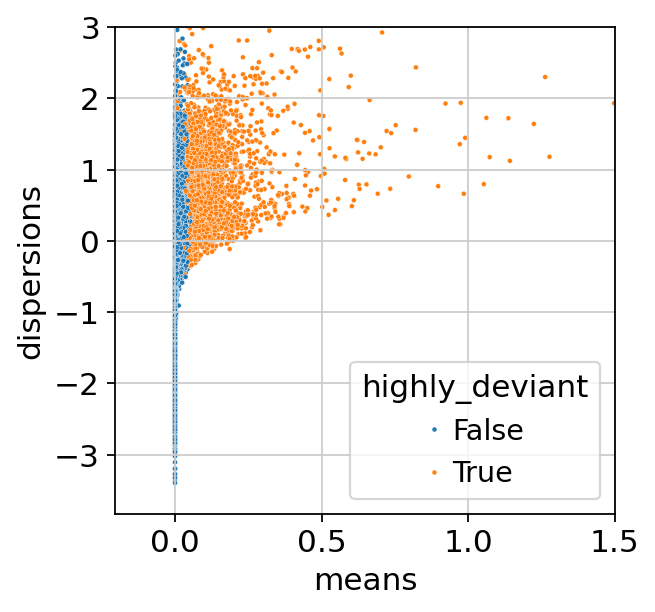

In [12]:
ro.globalenv['adata'] = anndata2ri.py2rpy(adata)
ro.r('sce <- as(adata, "SingleCellExperiment")')
ro.r('sce <- devianceFeatureSelection(sce, assay="X")')
binomial_deviance = np.array(ro.r('rowData(sce)$binomial_deviance')).T
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True
adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False, layer='log1p_norm')
ax = sns.scatterplot(data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

# Dimensionality reduction

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


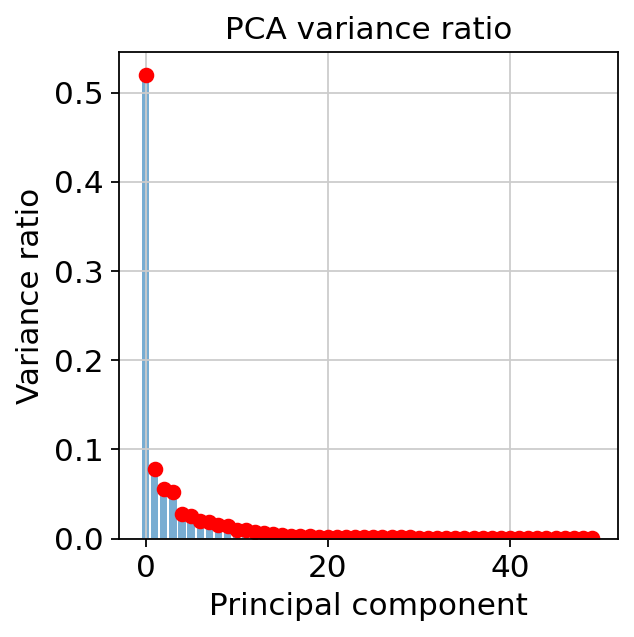

In [13]:
elbow_plot(adata, save_path='figures/elbow_plot.png')

In [14]:
sc.tl.pca(adata, n_comps=10, use_highly_variable=True)

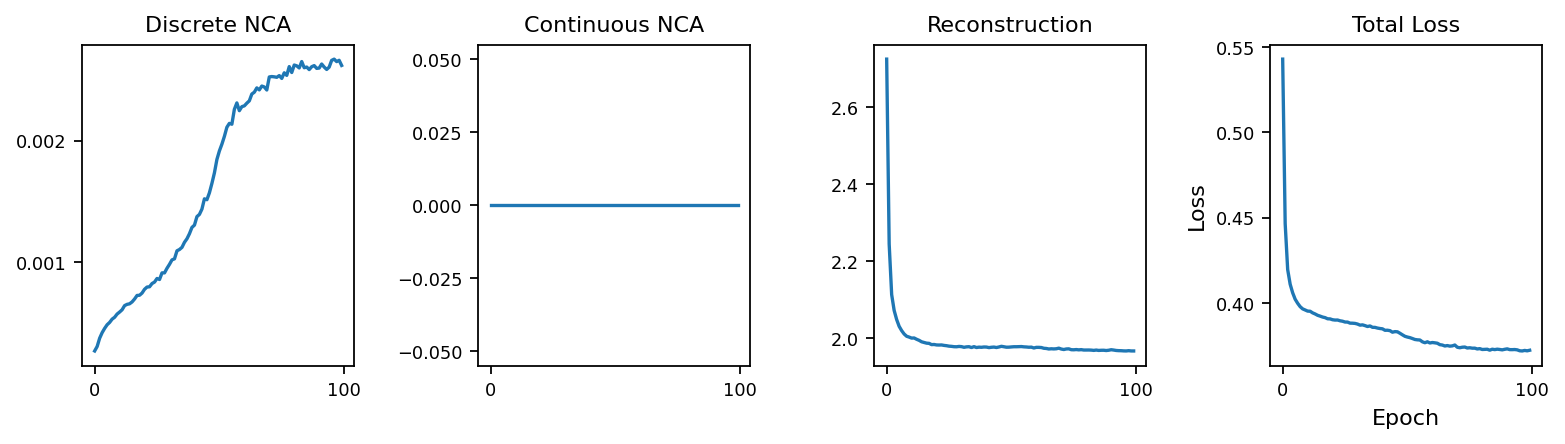

In [15]:
mcml = MCML(n_latent = 50, epochs = 100)
subclass_name = adata.obs['subclass_name'].values.tolist()
sample_tag = adata.obs['Sample_Tag'].values.tolist()
latentMCML = mcml.fit(adata.layers['scran_normalization'].toarray(), np.array([subclass_name]) , fracNCA = 0.8, silent = True)
#latentMCML = mcml.trainTest(adata.X, np.array([subclass_name, sample_tag]) , fracNCA = 0.8, silent = True)
mcml.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8, fname=None)
adata.obsm['latents'] = latentMCML
mcml_latents = adata.obsm['latents']

# #Pairwise distances between centroids of cells in each label
# cDists = tl.getCentroidDists(mcml_latents, np.array(subclass_name)) 

# #Avg pairwise distances between cells of *both* sexes, for each cell type
# interDists = tl.getInterVar(mcml_latents, np.array(subclass_name), np.array(sample_tag))  

# #Avg pairwise distances between cells of the *same* sex, for each cell type
# intraDists = tl.getIntraVar(mcml_latents, np.array(subclass_name), np.array(sample_tag)) 

# #Fraction of neighbors for each cell with same label as cell itself (also returns which labels neighbors have)
# neighbor_fracs, which_labels = tl.frac_unique_neighbors(mcml_latents, np.array(subclass_name), metric = 1,neighbors = 30)

# #Get nearest neighbors for any embedding
# orig_neigh = tl.getNeighbors(adata.X, n_neigh = 15, p=1)
# latent_neigh = tl.getNeighbors(mcml_latents, n_neigh = 15, p=1)

# #Get Jaccard distance between latent and ambient nearest neighbors
# jac_dists = tl.getJaccard(orig_neigh, latent_neigh)

# Batch correction

In [ ]:
harmony_out = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'Sample_Tag')
adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

# Clustering

In [16]:
sc.pp.neighbors(adata, use_rep='latents', n_pcs=50)
sc.tl.leiden(adata, resolution=0.25)

/tmp/ipykernel_12717/3982804432.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.25)


# Visualization

In [17]:
sc.tl.umap(adata)

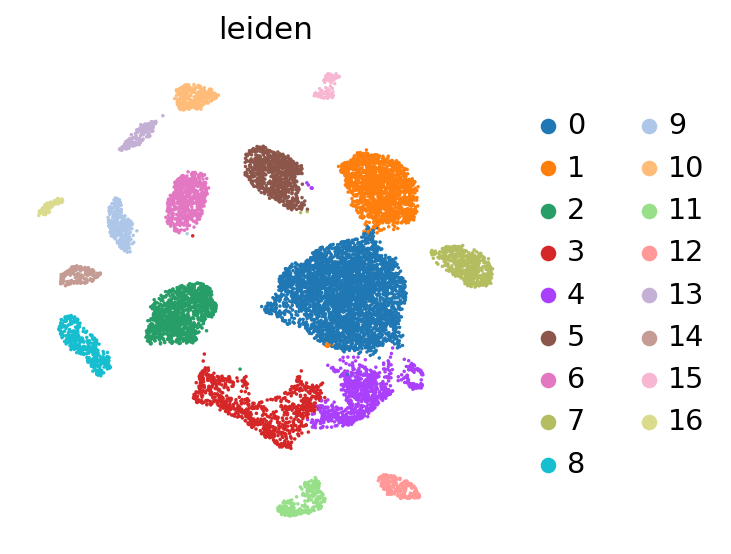

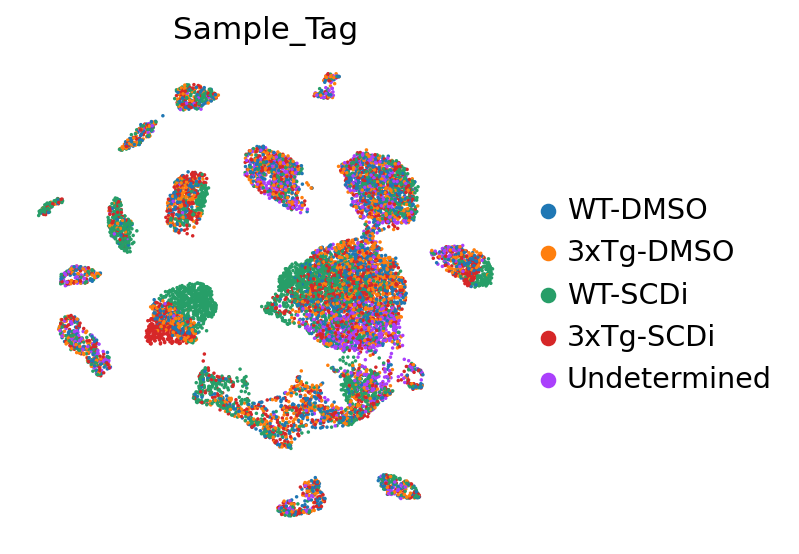

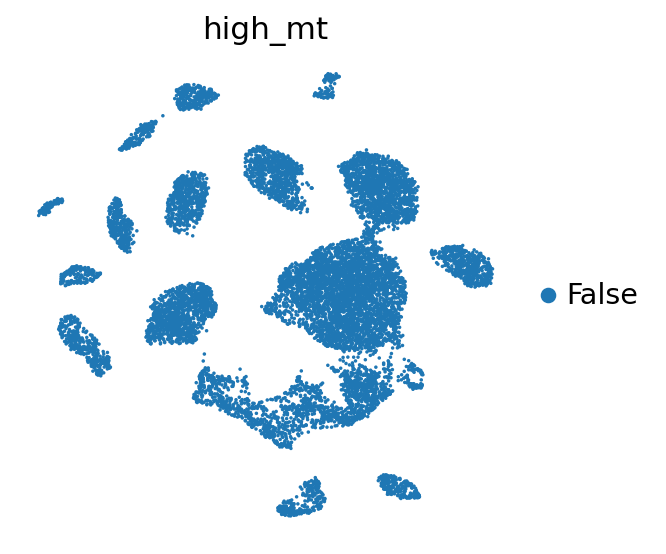

In [18]:
sc.pl.umap(adata, color=['leiden'], save='_leiden.png')
sc.pl.umap(adata, color=['Sample_Tag'], save='_sample_tag.png')
sc.pl.umap(adata, color=['high_mt'], save='_high_mt.png')

# Cluster annotation

In [19]:
assign_unique_cell_type_names(adata, cluster_key='leiden', cluster_types=['class_name', 'subclass_name', 'supertype_name'])

# Cluster visualization

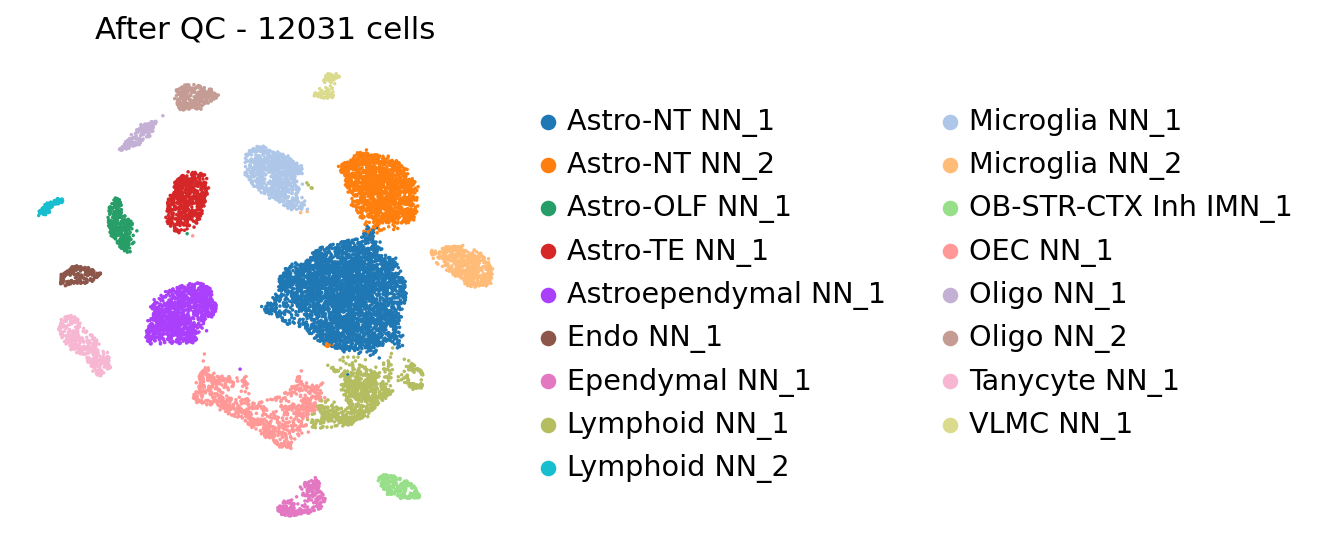

In [20]:
sc.pl.umap(adata, color=['cluster_subclass_name'], save='_subcluster_anno.png', title=f'After QC - {adata.shape[0]} cells', size=10)

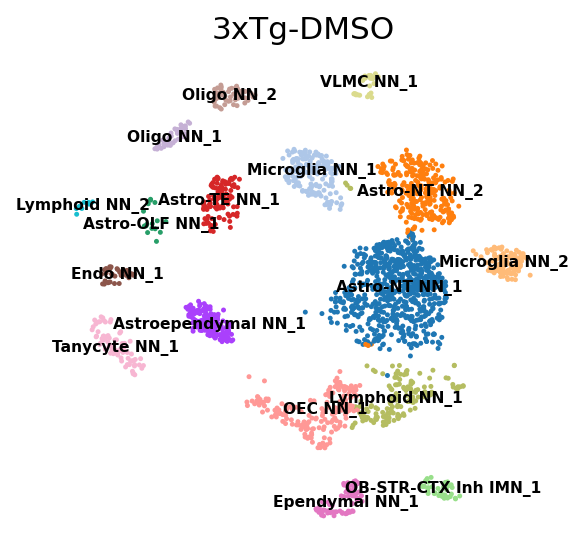

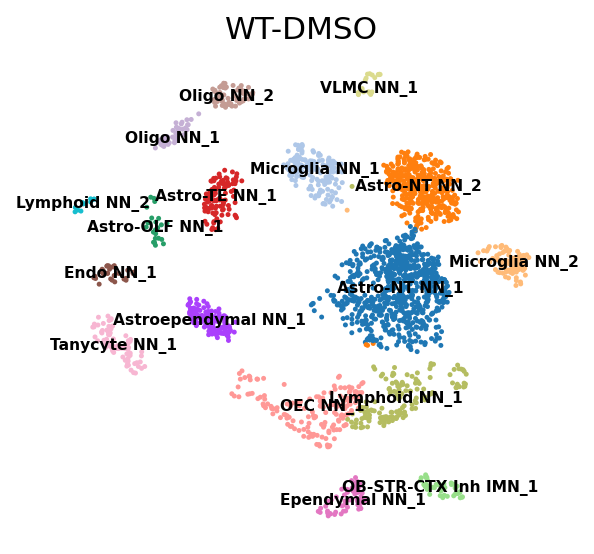

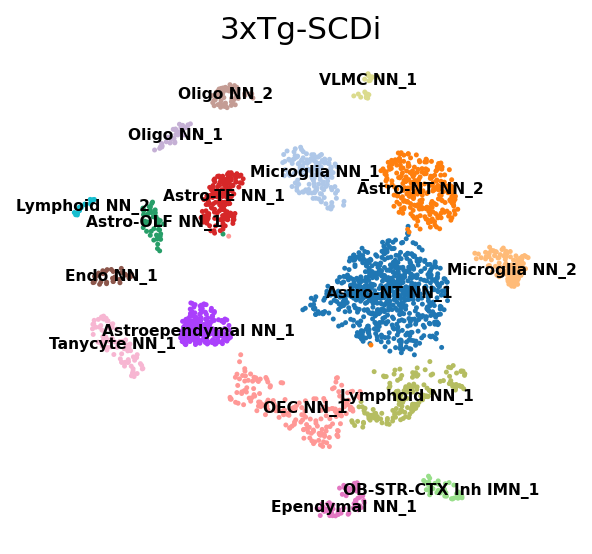

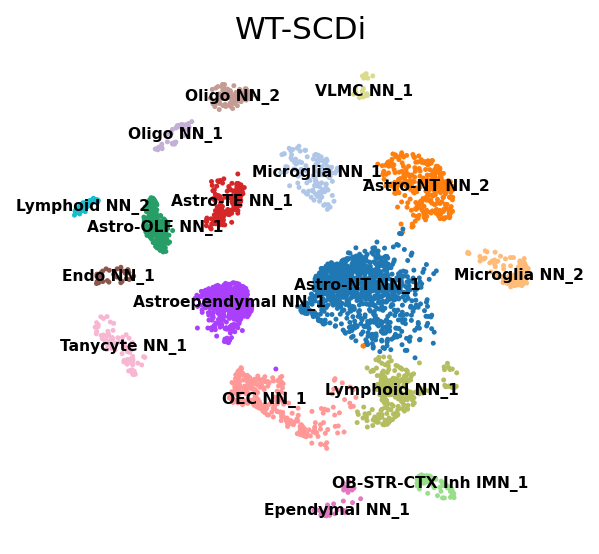

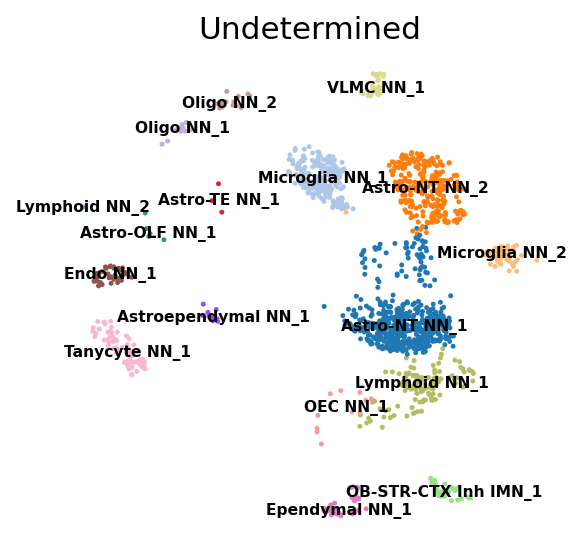

In [21]:
plot_umap(adata, cluster_type='cluster_subclass_name', legend_fontsize=7, save_path='_sample_tag')

# Master table

In [22]:
sample_tag_counts = get_master_table(adata, cluster_type='cluster_subclass_name', save_path='figures/master_table.xlsx')

/home/client/projects/sc_alz/modules/visualize.py:193: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_df = merged_df.groupby(cluster_type).size().reset_index(name='total_count')
/home/client/projects/sc_alz/modules/visualize.py:194: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_tag_counts = merged_df.groupby([cluster_type, 'Sample_Tag']).size().unstack(fill_value=0)


In [23]:
df_filter = sample_tag_counts[sample_tag_counts.index.str.startswith('Astro-NT')]
df_percentage = df_filter.div(df_filter.sum(axis=0), axis=1) * 100
#df_percentage = sample_tag_counts.div(sample_tag_counts.sum(axis=0), axis=1) * 100

# Clusters composition analysis

In [25]:
class_level, cluster_type = 'subclass_name', 'cluster_subclass_name'

/home/client/projects/sc_alz/modules/visualize.py:209: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby([cluster_type, class_level]).size().unstack(fill_value=0).fillna(0)


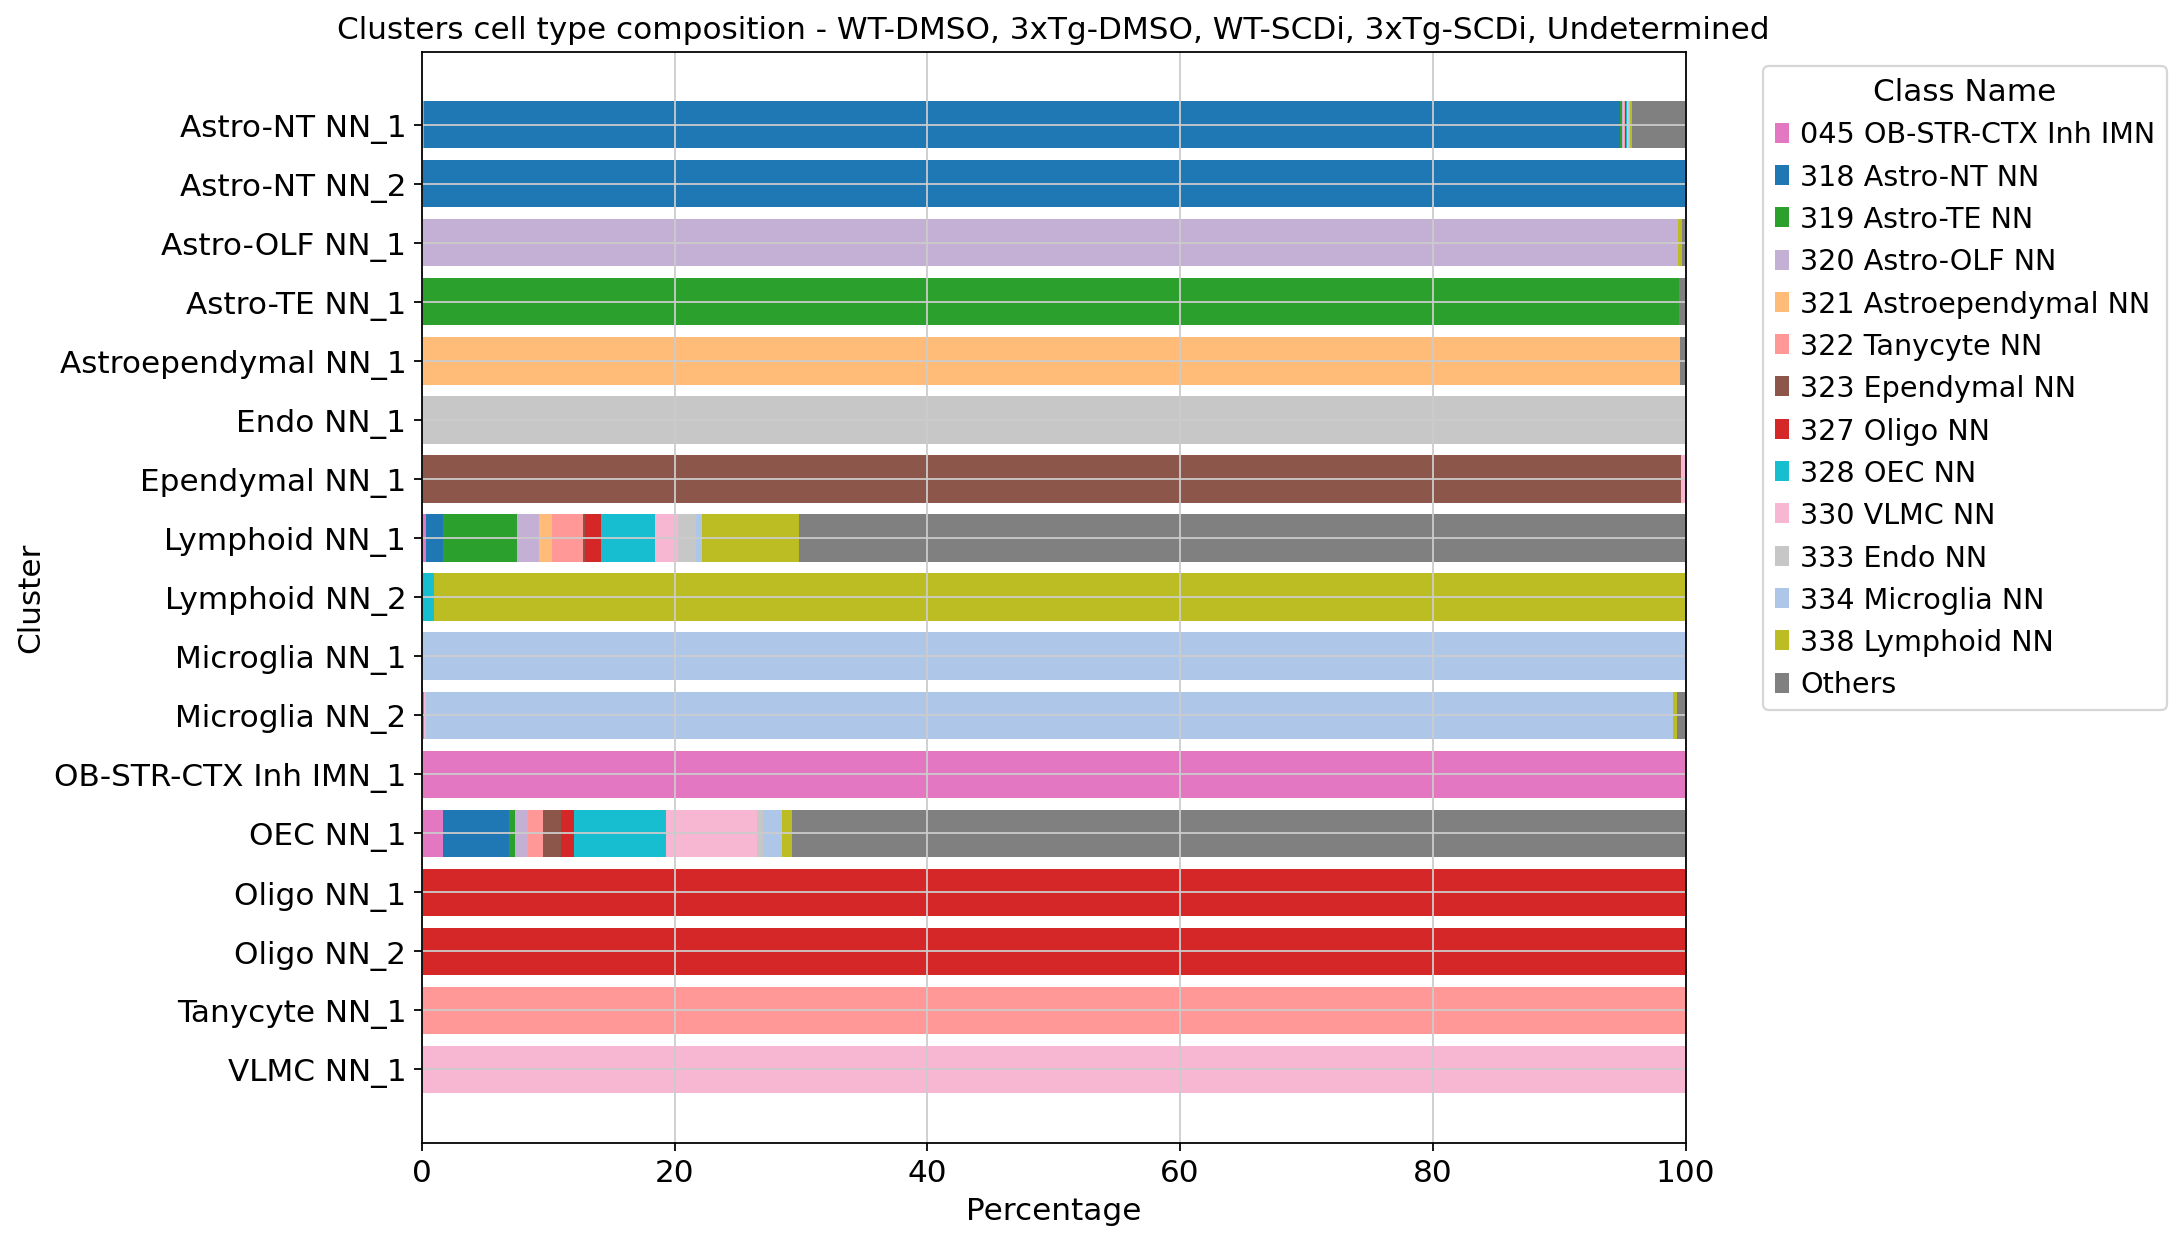

In [26]:
create_ditto_plot(adata, ['WT-DMSO', '3xTg-DMSO', 'WT-SCDi', '3xTg-SCDi', 'Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/all_ditto.png')

# DEG analysis

In [27]:
ctr_cell_types = [x for x in set(adata.obs.cluster_subclass_name.values) if x.startswith('Astro-NT')]
ctr_sample_tags = [x for x in set(adata.obs.Sample_Tag.values)]
ctr_sample_tags = ['WT-DMSO']

cnd_cell_types = [x for x in set(adata.obs.cluster_subclass_name.values) if x.startswith('Astro-NT')]
cnd_sample_tags = [x for x in set(adata.obs.Sample_Tag.values)]
cnd_sample_tags = ['3xTg-DMSO']

In [28]:
ctr_idx = adata[(adata.obs['Sample_Tag'].isin(ctr_sample_tags)) & (adata.obs['cluster_subclass_name'].isin(ctr_cell_types))].obs.index
cnd_idx = adata[(adata.obs['Sample_Tag'].isin(cnd_sample_tags)) & (adata.obs['cluster_subclass_name'].isin(cnd_cell_types))].obs.index
ctr_name = 'Astro-NT WT-DMSO'
cnd_name = 'Astro-NT 3xTg-DMSO'

In [29]:
adata.obs['group'] = ['control' if i in ctr_idx else 'condition' if i in cnd_idx else 'undefined' for i in adata.obs.index]

In [30]:
filtered_adata = adata[adata.obs['group'] != 'undefined']

In [ ]:
wilcoxon_df = DEG_analysis(filtered_adata,
                           save_path=f'figures/{ctr_name}_{cnd_name}_results_df.pkl')

In [37]:
mast_df = DEG_analysis_mast(filtered_adata,
                            save_path=f'figures/{ctr_name}_{cnd_name}_results_df.pkl')

[1] "Shape of exprs_data: 25244 x 2070"
[1] "Shape of cdata: 2070 x 3"
[1] "Shape of fdata: 25244 x 1"


In [ ]:
# deseq2_df = DEG_analysis_deseq2_pseudobulk(filtered_adata,
#                                            save_path=f'figures/{ctr_name}_{cnd_name}_results_df.pkl')

In [38]:
results_df = mast_df

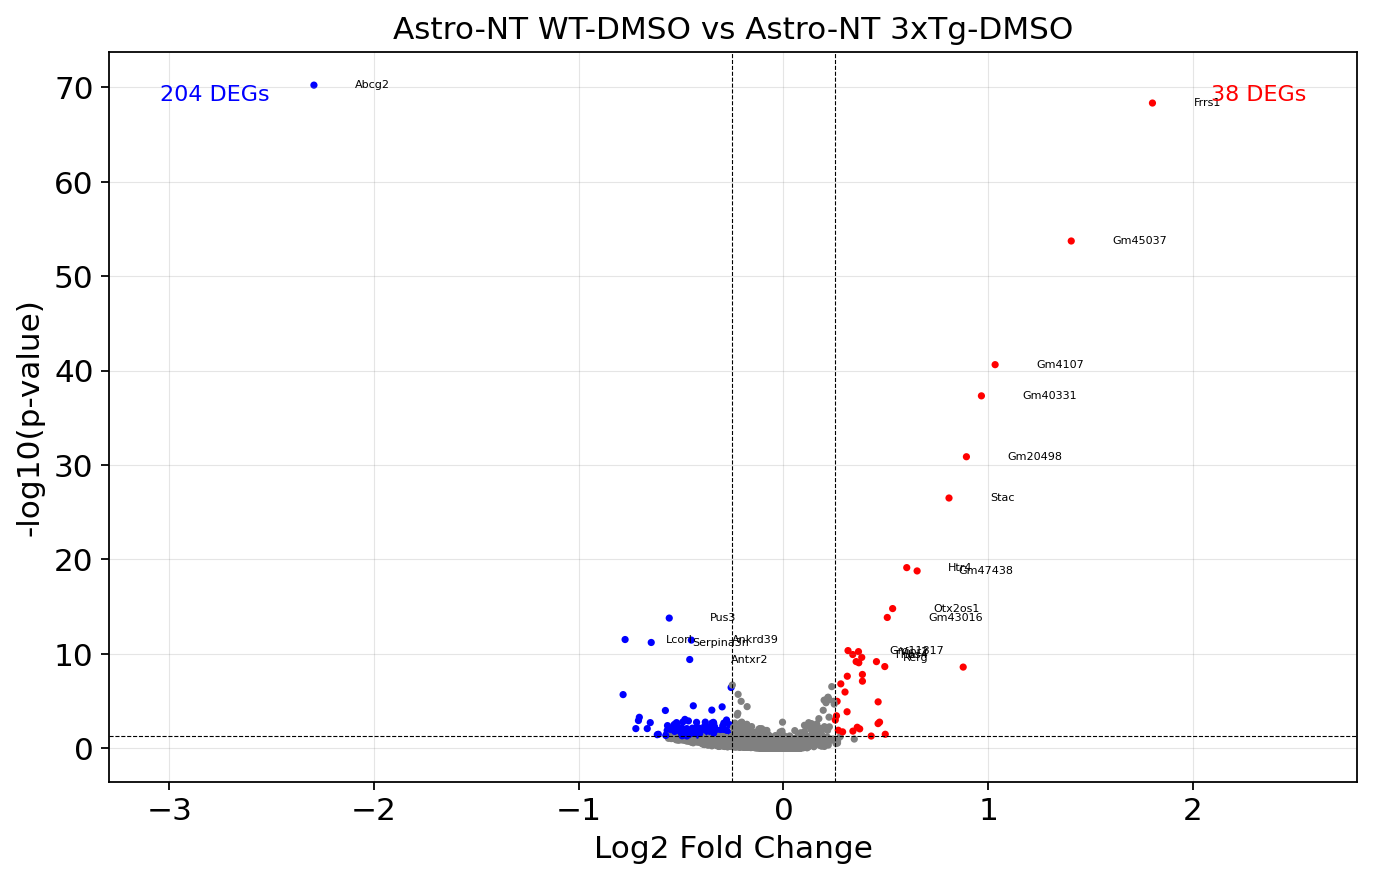

In [39]:
volcano_plot(results_df,
             min_fold_change=0.25,
             max_p_value=0.05,
             fig_title=f'{ctr_name} vs {cnd_name}',
             save_path=f'figures/{ctr_name}_{cnd_name}_volcano_plot.png')

# GO term enrichment analysis

In [40]:
UP_genes_name, DOWN_genes_name = get_DEGs(results_df,
                                          max_pval=0.05,
                                          min_fold_change=0.25)

In [41]:
UP_GO = go_enrichment_analysis(UP_genes_name, save_path=None)
DOWN_GO = go_enrichment_analysis(DOWN_genes_name, save_path=None)

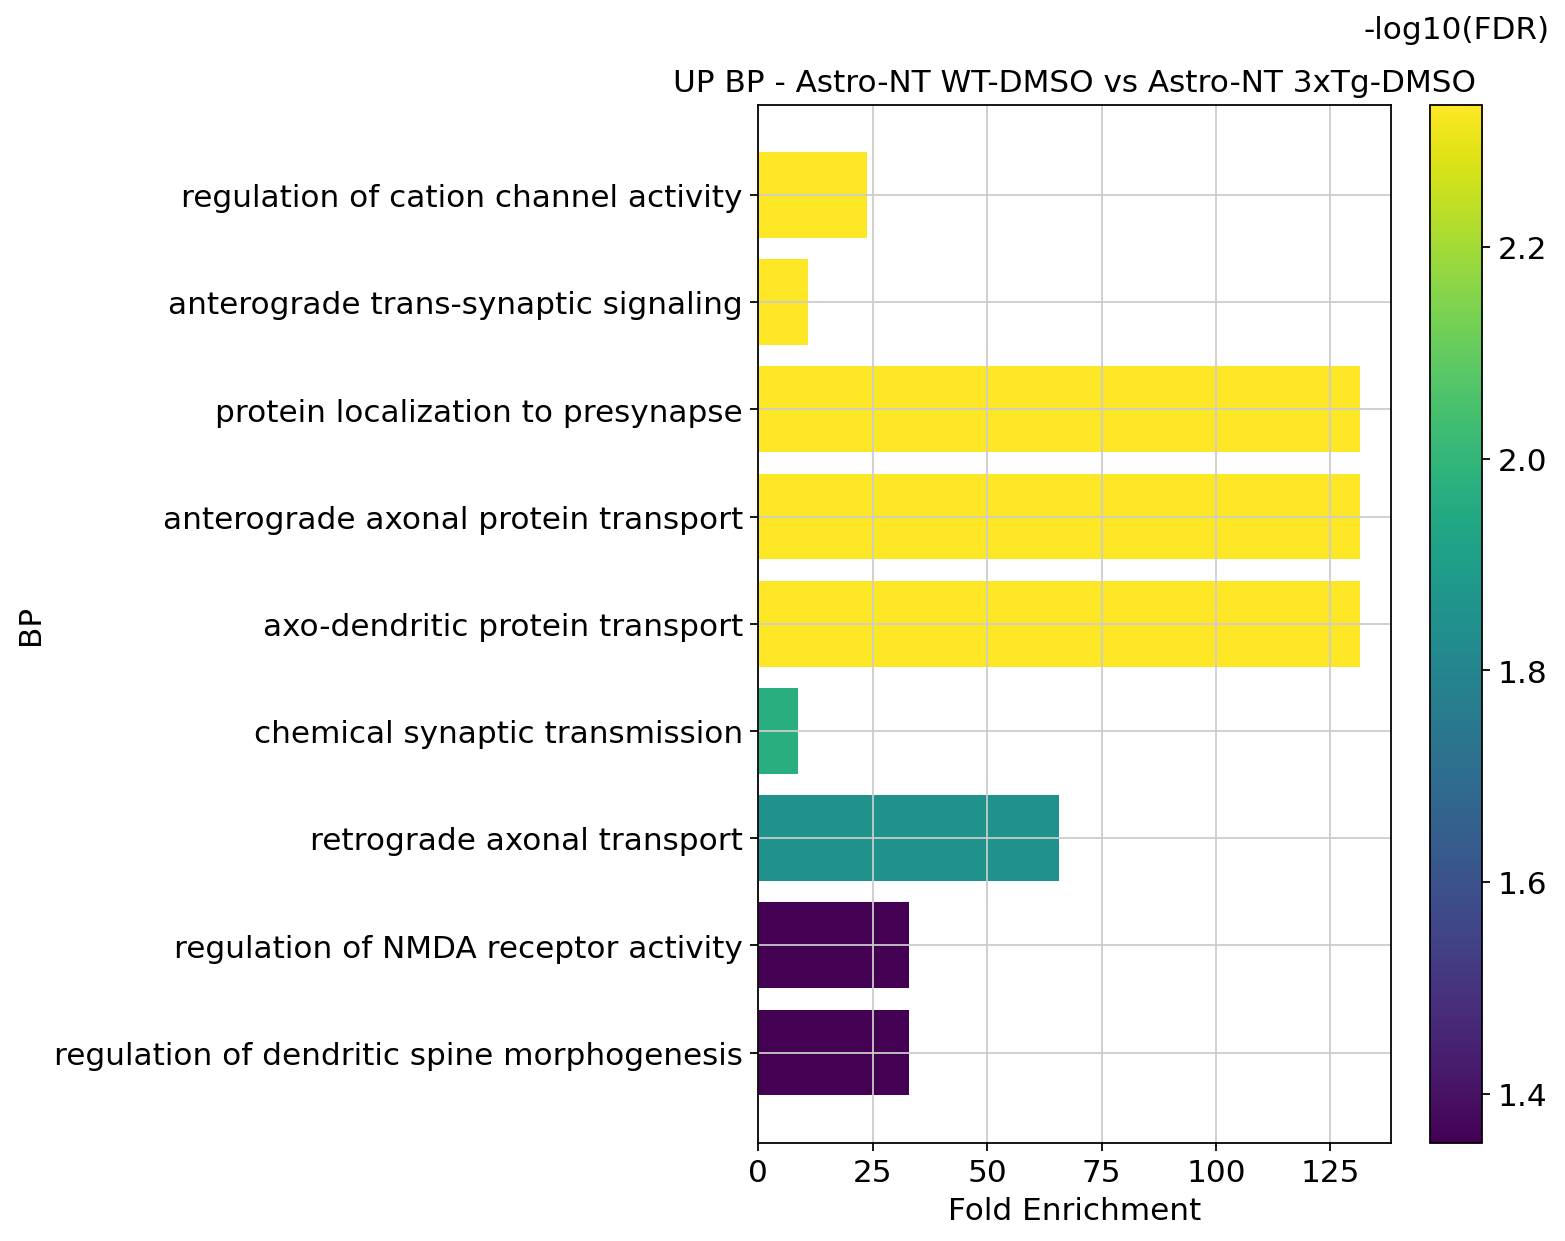

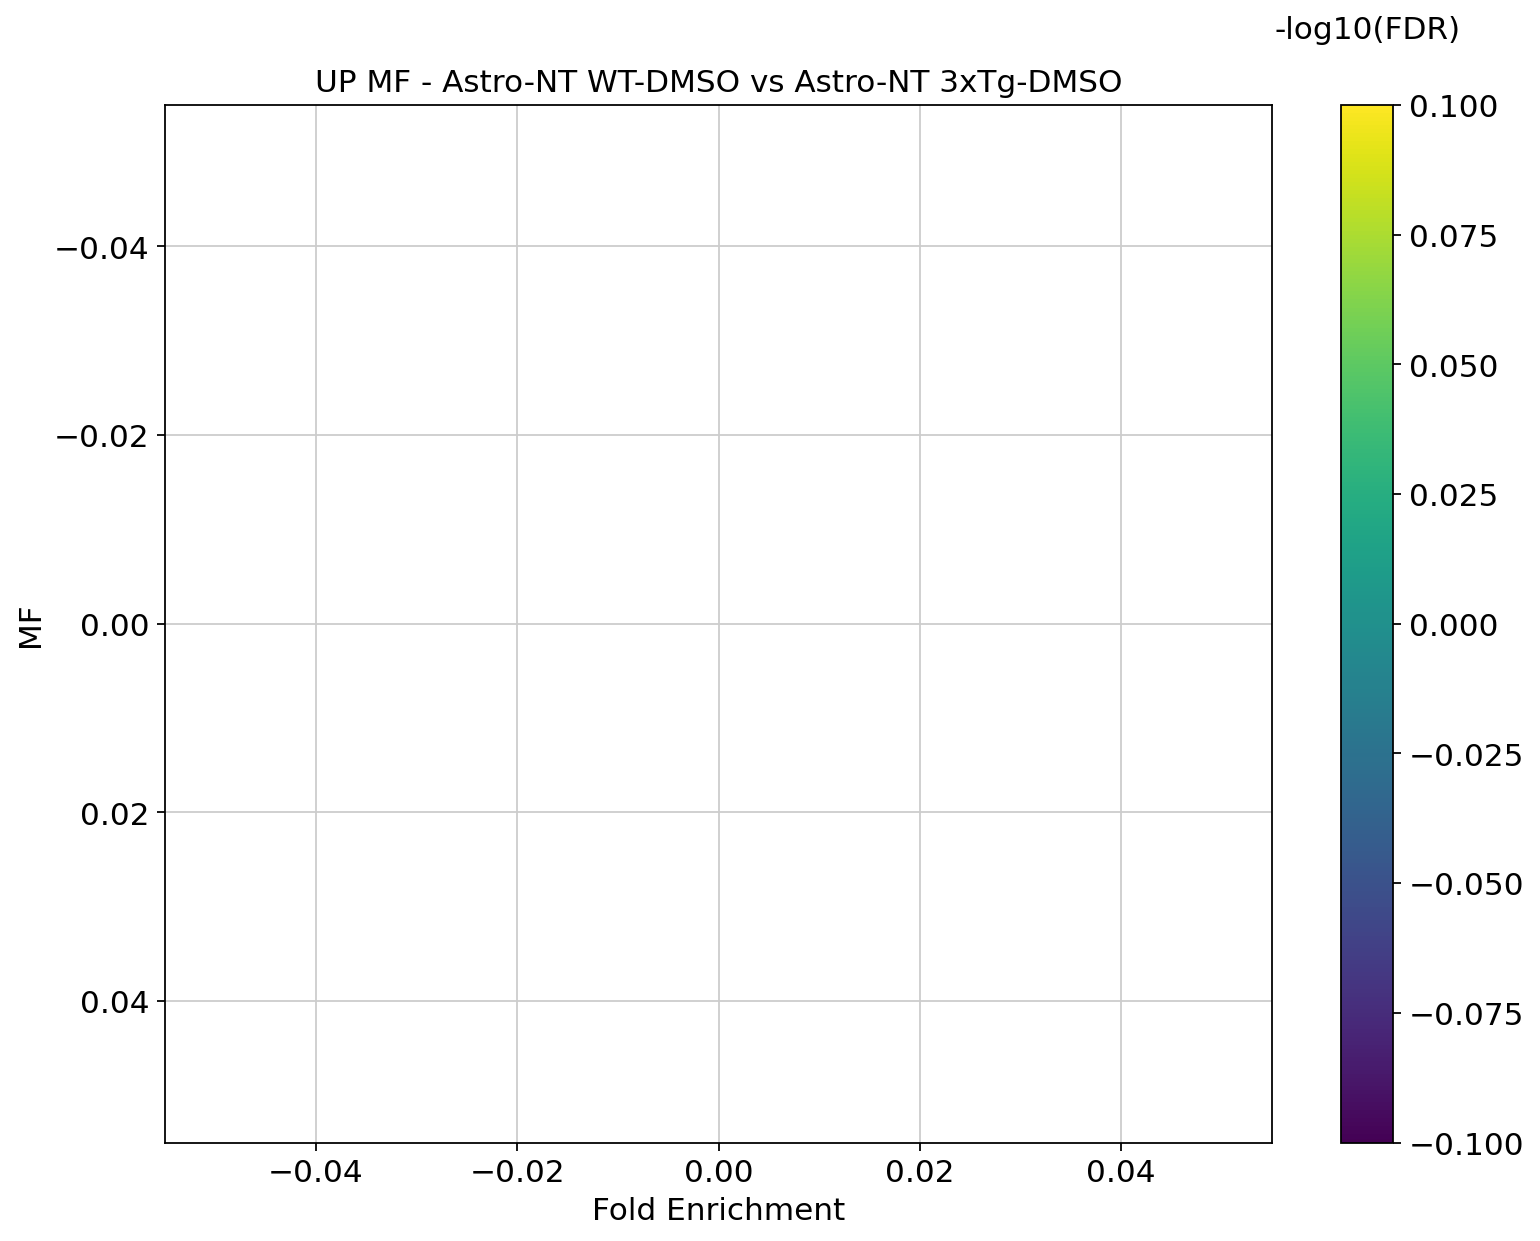

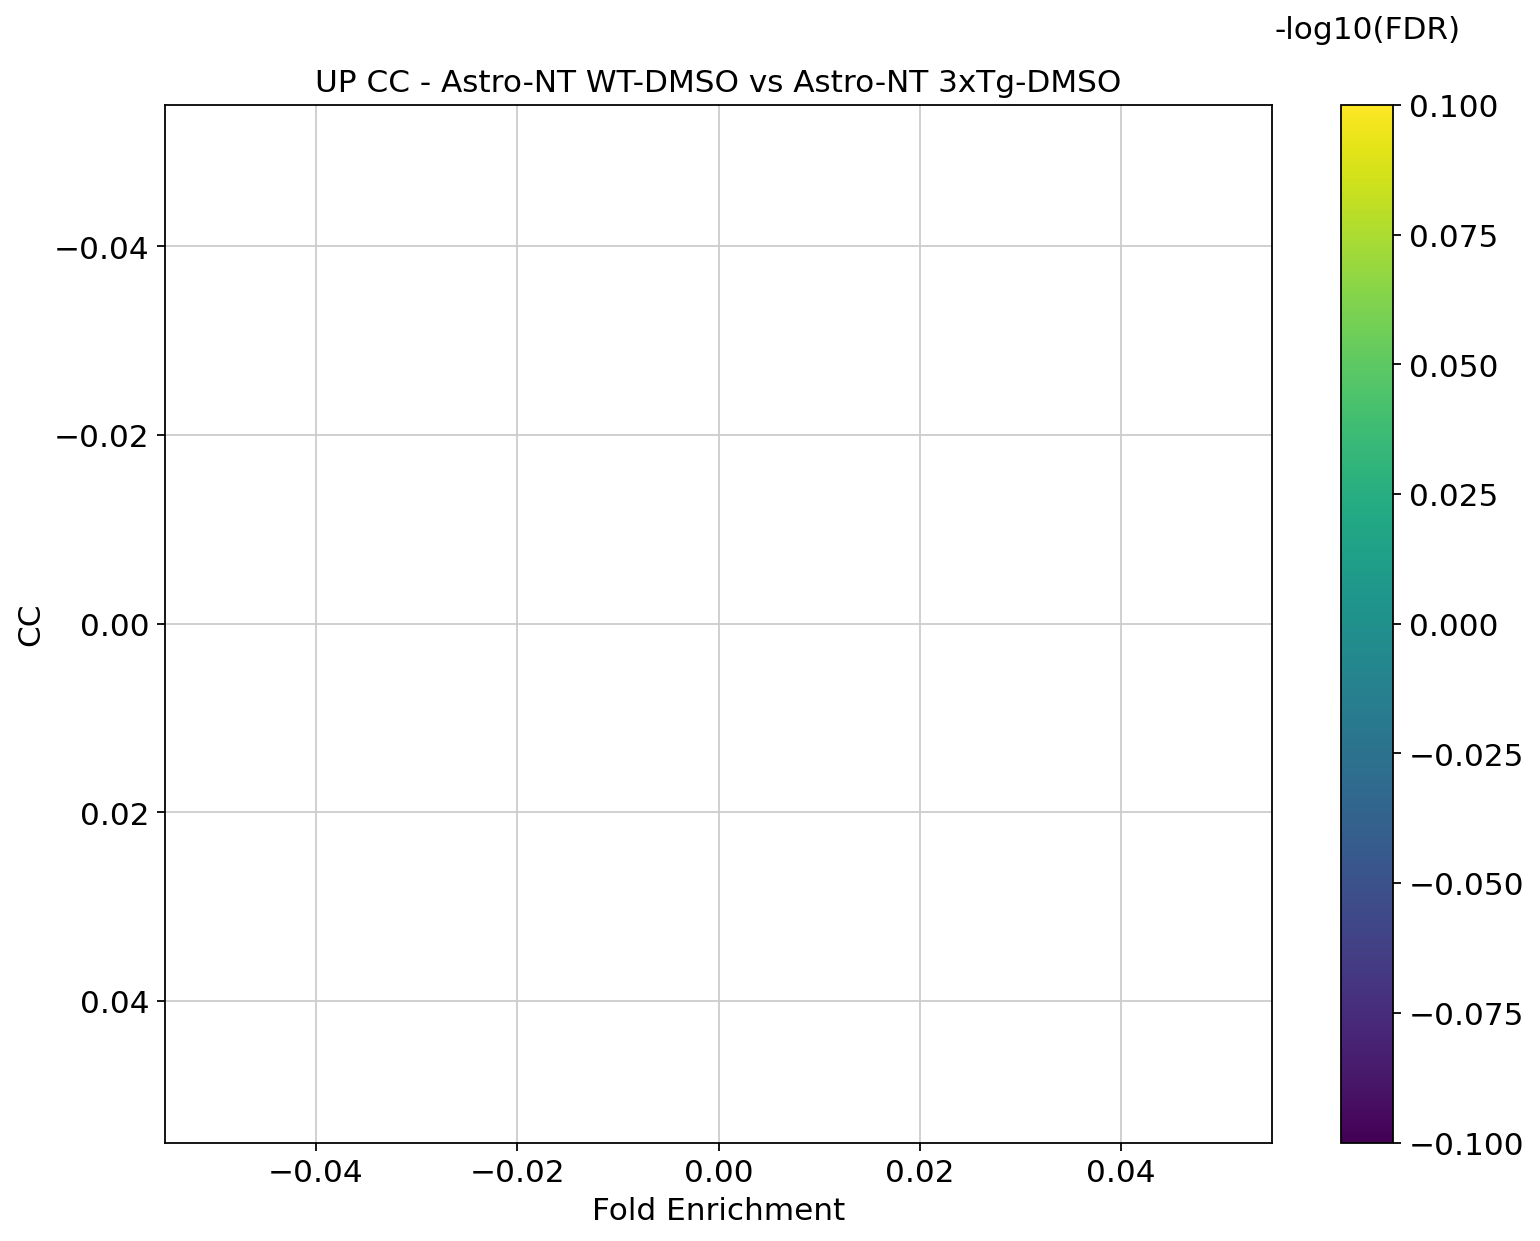

In [42]:
display_go_enrichment(UP_GO,
                      namespace='BP',
                      fig_title=f'UP BP - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_BP')

display_go_enrichment(UP_GO, 
                      namespace='MF',
                      fig_title=f'UP MF - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_MF')

display_go_enrichment(UP_GO, 
                      namespace='CC',
                      fig_title=f'UP CC - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_CC')

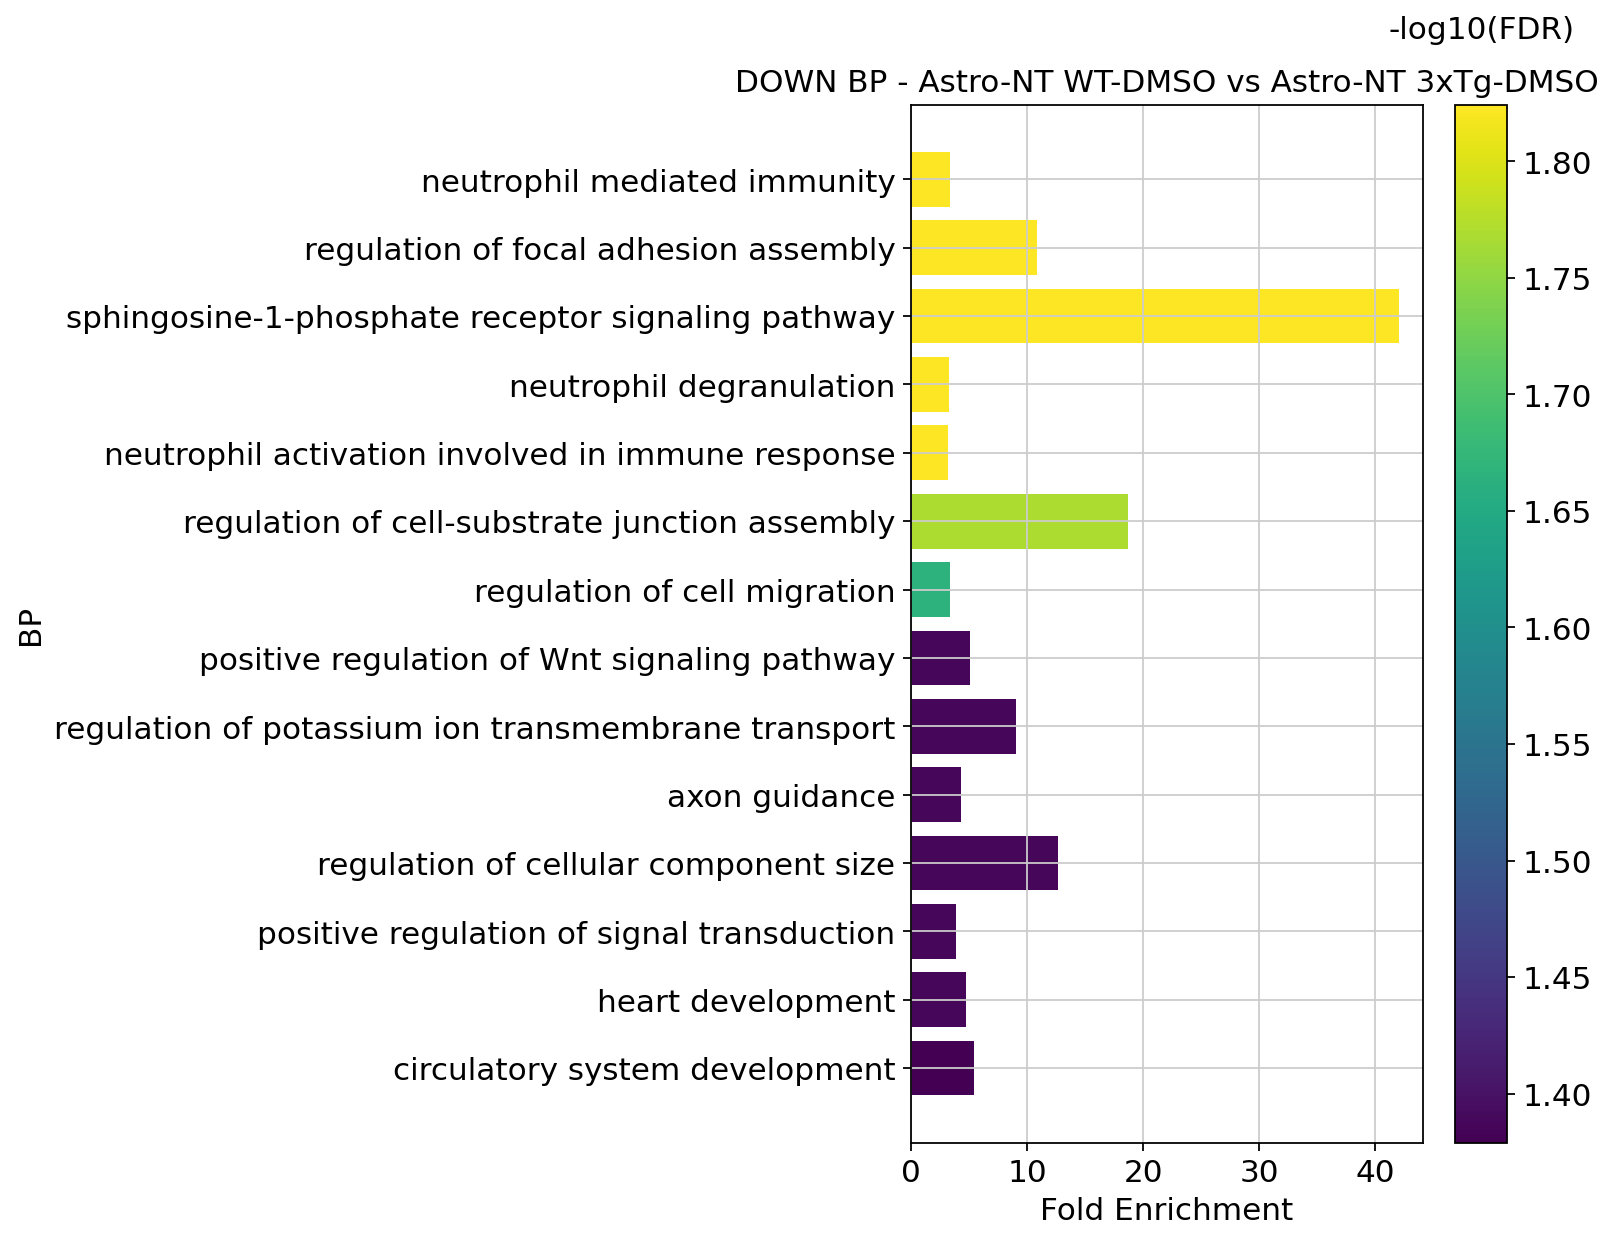

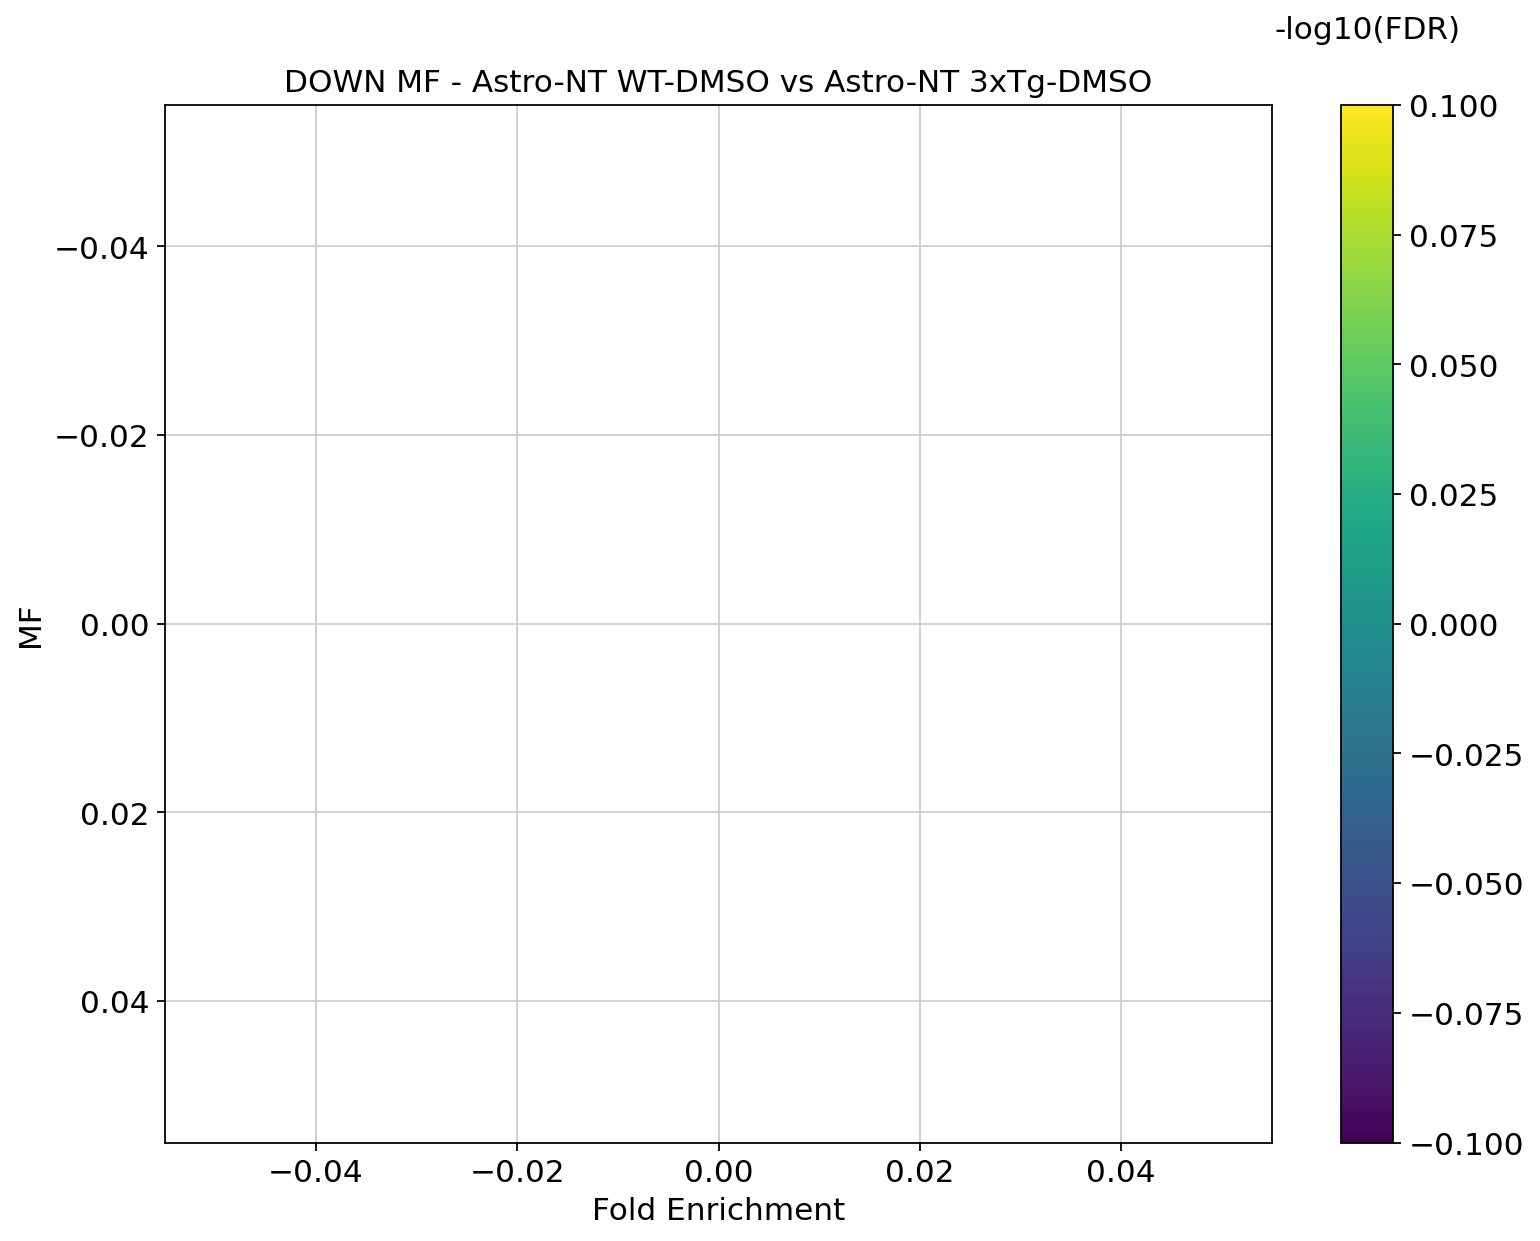

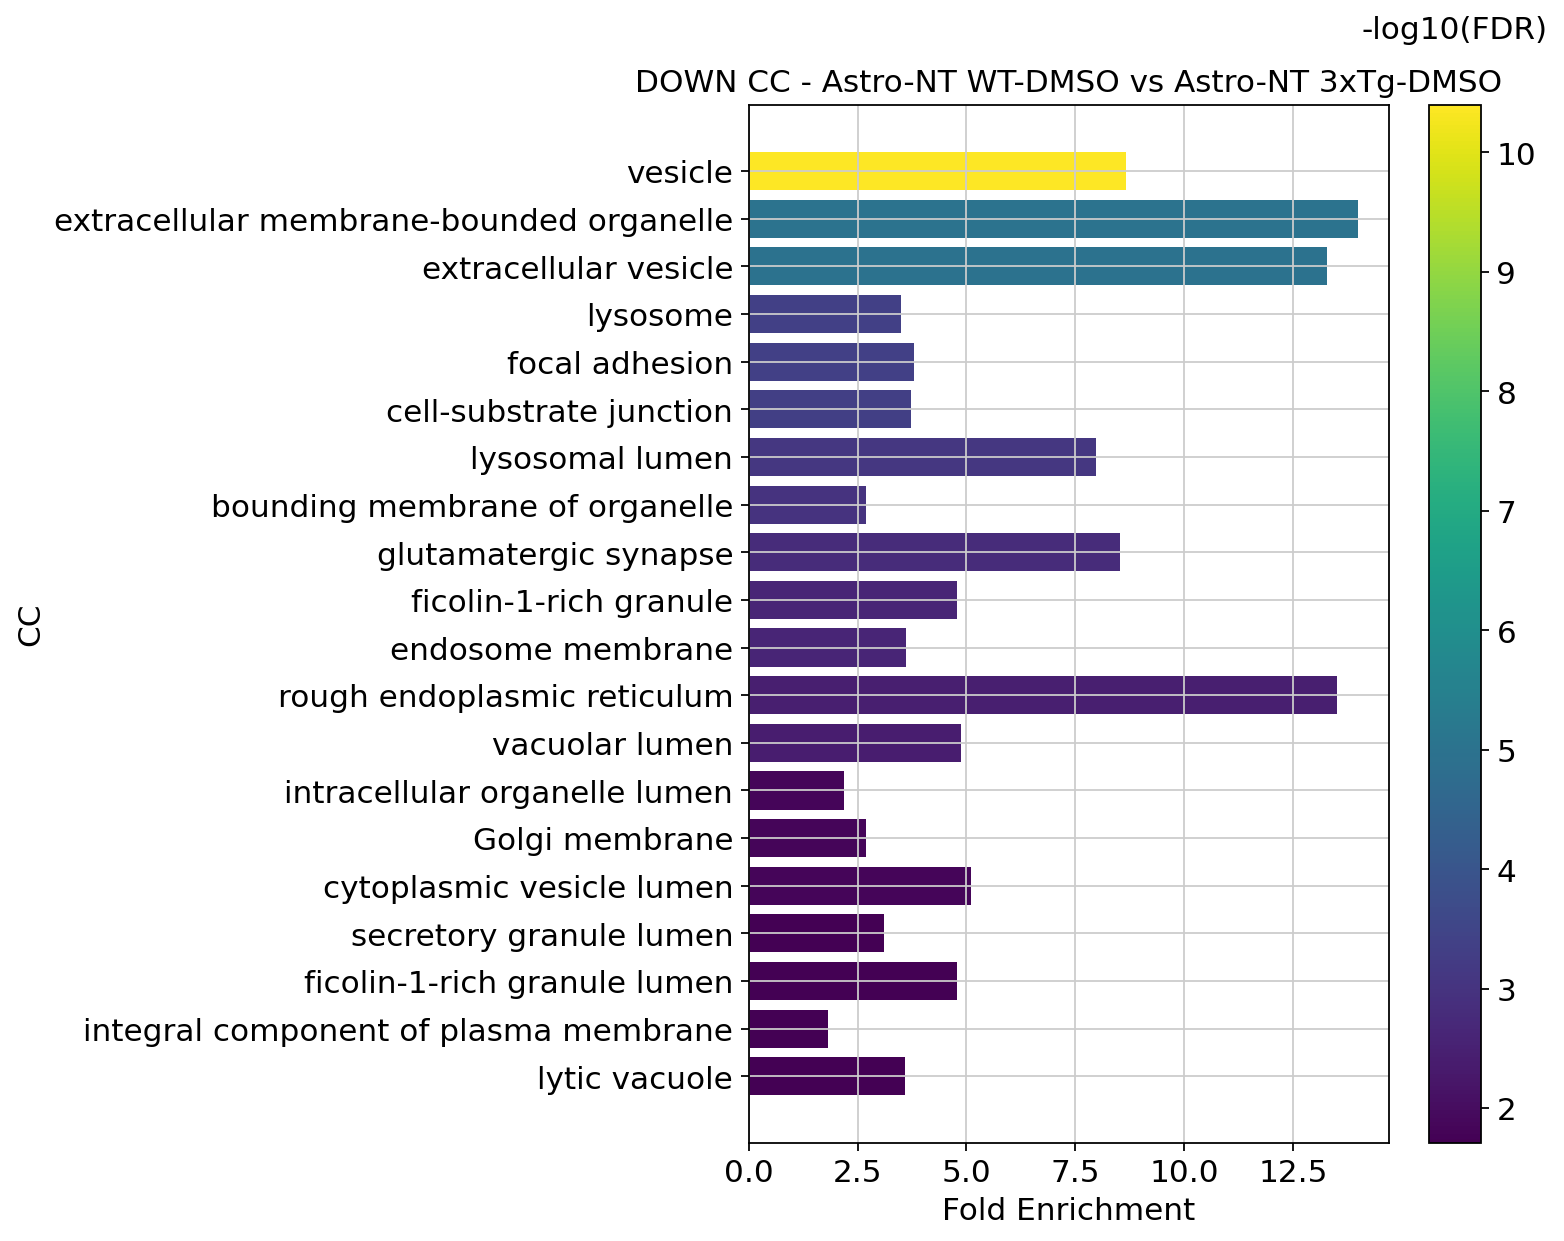

In [43]:
display_go_enrichment(DOWN_GO, 
                      namespace='BP',
                      fig_title=f'DOWN BP - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_BP')

display_go_enrichment(DOWN_GO, 
                      namespace='MF',
                      fig_title=f'DOWN MF - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_MF')

display_go_enrichment(DOWN_GO, 
                      namespace='CC',
                      fig_title=f'DOWN CC - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_CC')

In [44]:
UP_KEGG = kegg_enrichment_analysis(UP_genes_name, 
                                   save_path=None)

In [45]:
DOWN_KEGG = kegg_enrichment_analysis(DOWN_genes_name, 
                                     save_path=None)

/home/client/projects/sc_alz/modules/deg_analysis.py:535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm = plt.Normalize(top_processes['-log10(FDR)'].min(), top_processes['-log10(FDR)'].max())


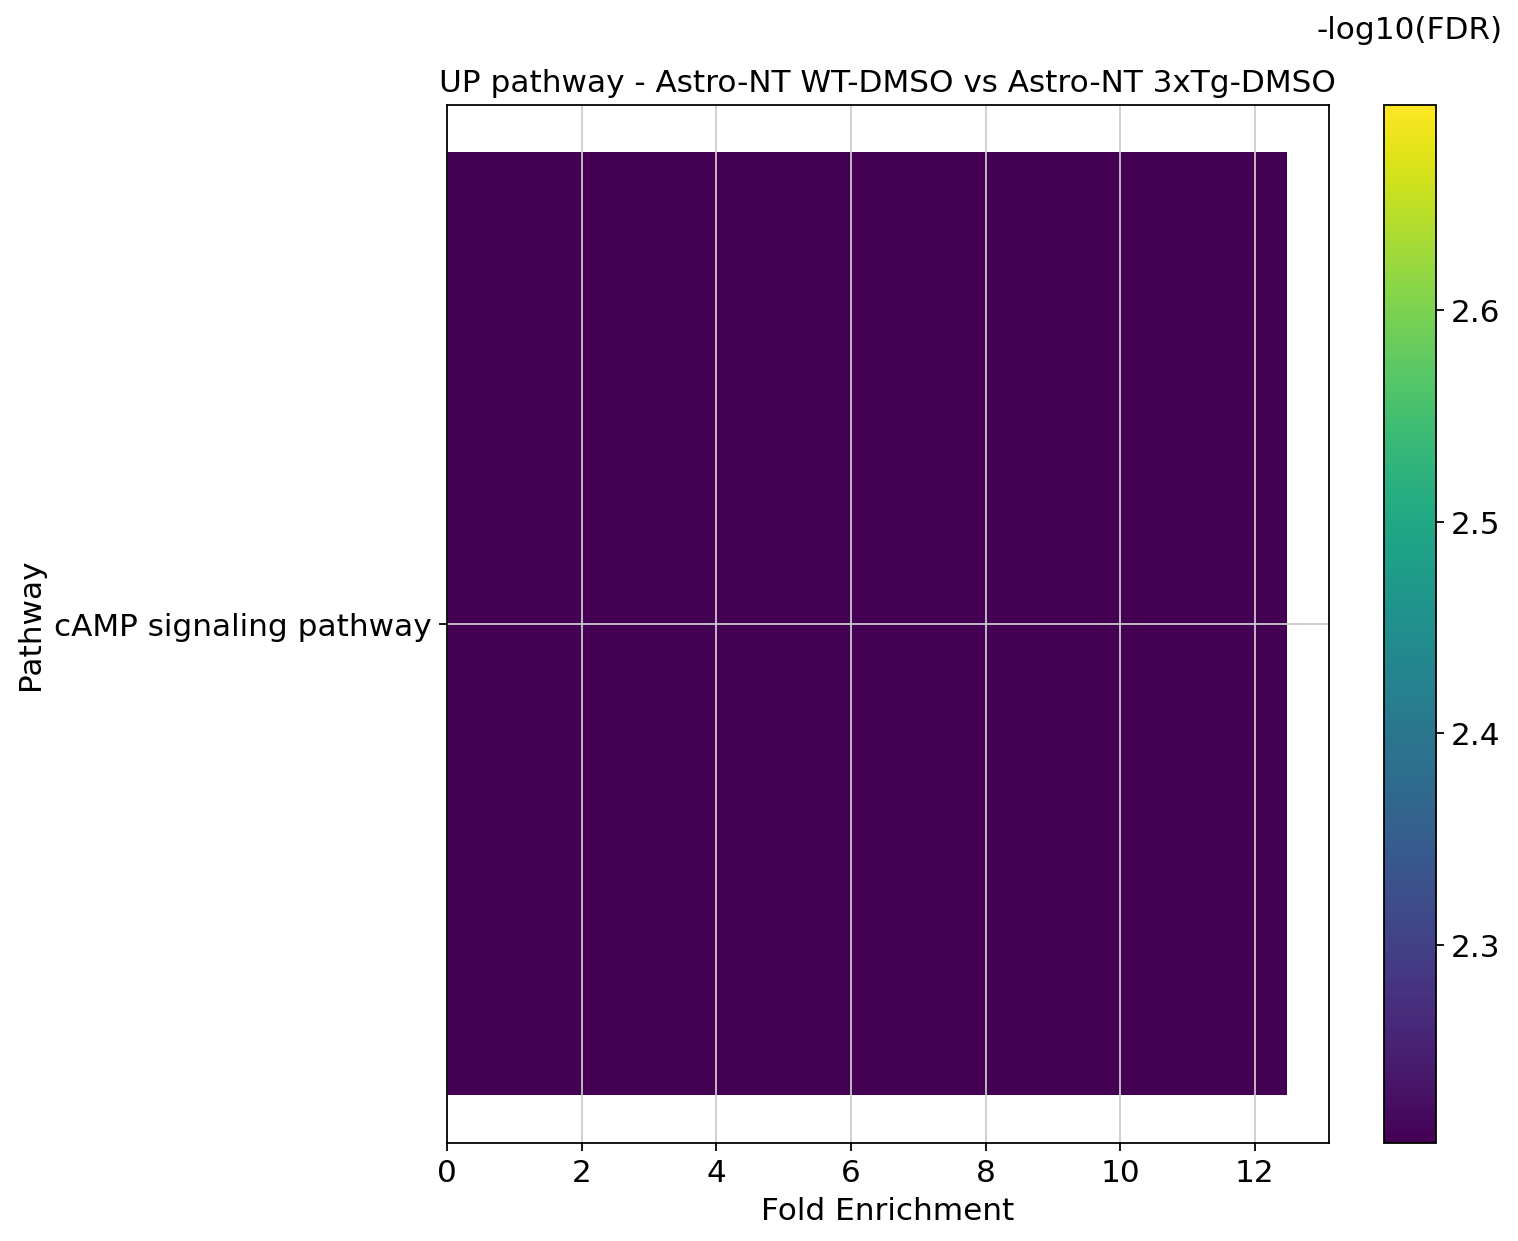

In [46]:
display_kegg_enrichment(UP_KEGG,
                        fig_title=f'UP pathway - {ctr_name} vs {cnd_name}',
                        save_path=f'figures/{ctr_name}_{cnd_name}_display_KEGG_enrichment_UP')

/home/client/projects/sc_alz/modules/deg_analysis.py:535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm = plt.Normalize(top_processes['-log10(FDR)'].min(), top_processes['-log10(FDR)'].max())


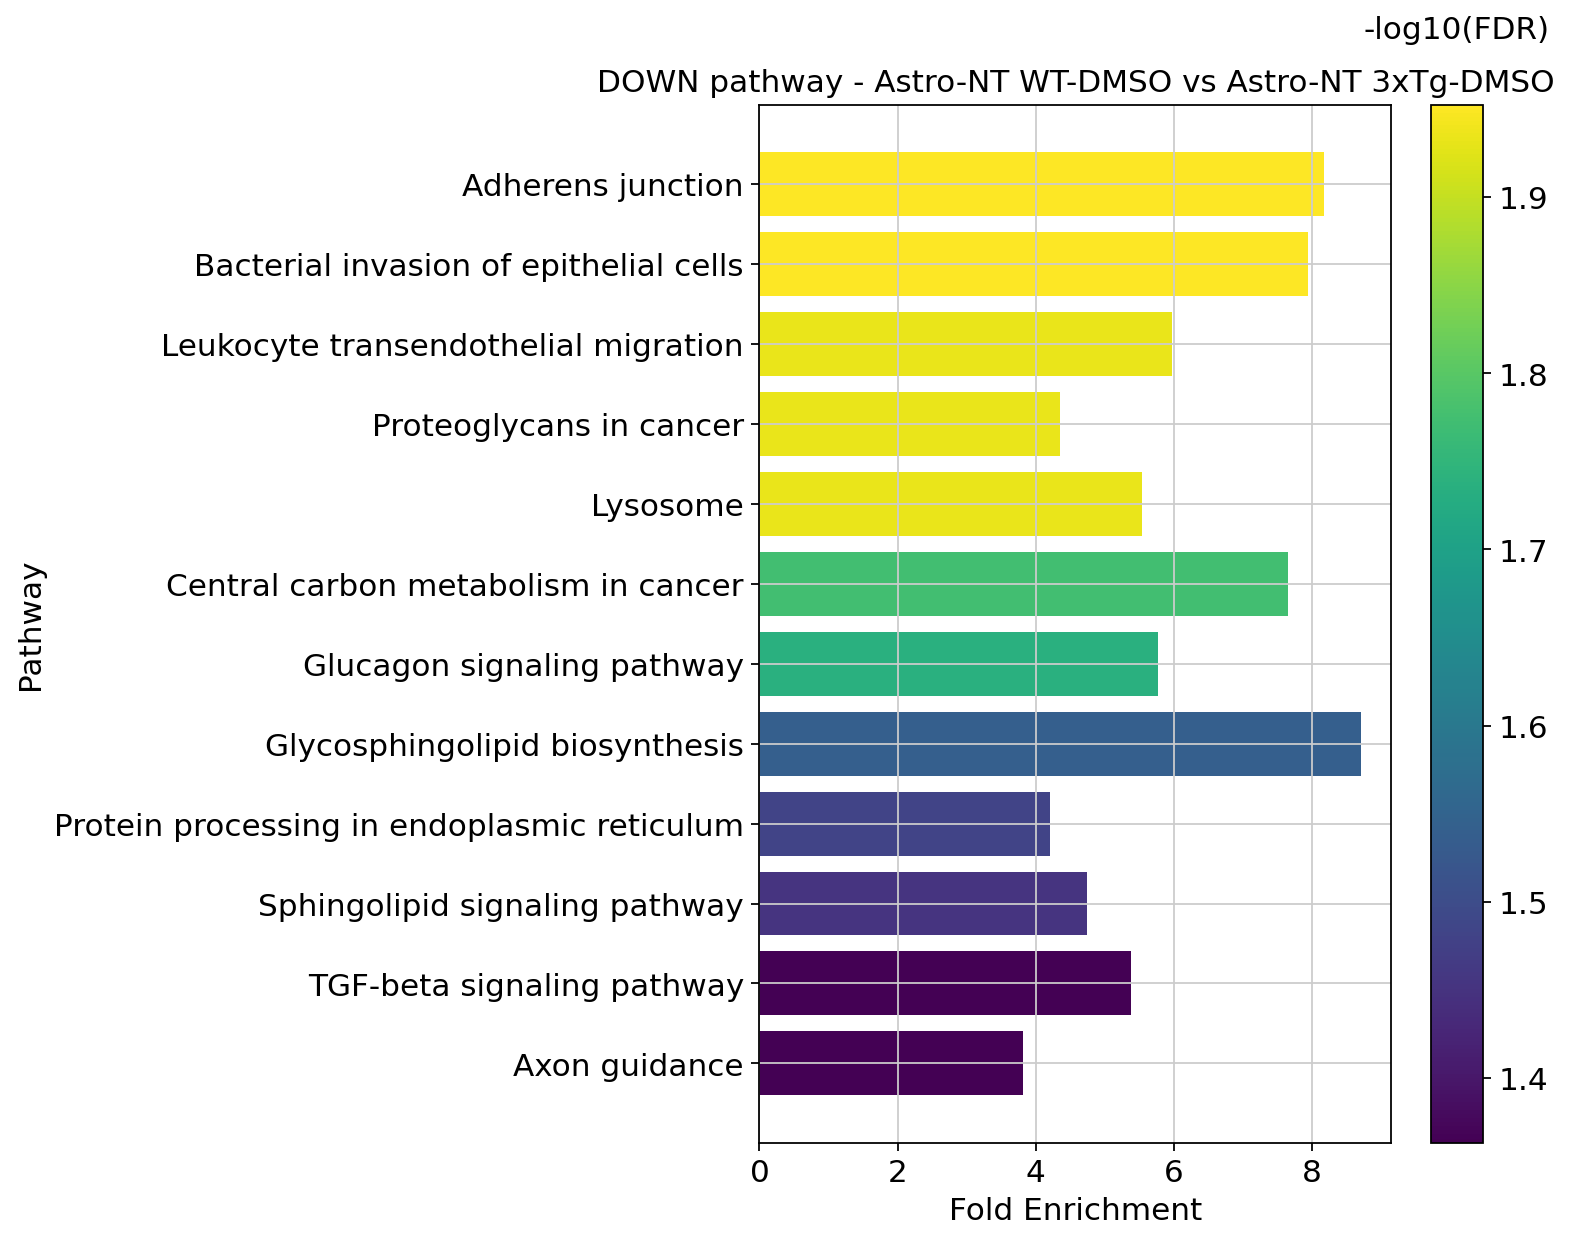

In [47]:
display_kegg_enrichment(DOWN_KEGG,
                        fig_title=f'DOWN pathway - {ctr_name} vs {cnd_name}',
                        save_path=f'figures/{ctr_name}_{cnd_name}_display_KEGG_enrichment_DOWN')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
def create_venn_diagram(df1, df2, tag1, tag2):
    """
    Creates a Venn diagram from two DataFrames based on specific conditions.
    
    Parameters:
    df1 (pd.DataFrame): The first DataFrame with 'names', 'log2FoldChange', and 'padj' columns.
    df2 (pd.DataFrame): The second DataFrame with 'names', 'log2FoldChange', and 'padj' columns.
    tag1 (str): Label for the first DataFrame in the Venn diagram.
    tag2 (str): Label for the second DataFrame in the Venn diagram.
    """
    # Filter the dataframes based on the conditions
    filtered_df1 = df1[(df1['log2FoldChange'].abs() > 0.25) & (df1['padj'] < 0.05)]
    filtered_df2 = df2[(df2['log2FoldChange'].abs() > 0.25) & (df2['padj'] < 0.05)]
    
    # Convert the 'names' columns to sets
    set1 = set(filtered_df1['names'])
    set2 = set(filtered_df2['names'])
    
    # Create the Venn diagram
    plt.figure(figsize=(8, 8))
    venn2([set1, set2], (tag1, tag2))
    
    # Save the figure with padding
    plt.savefig(f'figures/venn_{tag1}_{tag2}.png', bbox_inches='tight')
    plt.show()

In [ ]:
create_venn_diagram(wtd_3xtgd, wtd_3xtgs, 'All Astro WT-DMSO vs 3xTG DMSO', 'All Astro WT-DMSO vs 3xTG SCDi')